In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scripts import m5_common
from sklearn import datasets, linear_model

pd.options.display.max_columns = 50

### Path

In [3]:
path = Path('/kaggle/m5_forecasting/')
assert(path.exists())

In [4]:
h = 28
tr_last = 1941
fday = datetime(2016, 4, 25) + timedelta(days=h)
fday

datetime.datetime(2016, 5, 23, 0, 0)

In [5]:
%%time

prices, cal = m5_common.prepare_tables(path)

CPU times: user 1.41 s, sys: 172 ms, total: 1.58 s
Wall time: 1.58 s


In [6]:
weather_df = pd.read_csv(path/'weather/weather_2010_2020.csv')
weather_df["date"] = pd.to_datetime(weather_df["Date"])
del weather_df["Date"]
del weather_df["Anomaly"]
weather_df['Value'] = weather_df['Value'].astype('float16')
weather_df.columns = ['temperature',  'date']

In [7]:
# %%time

# cal = cal.merge(weather_df, on=['date'], copy = False)

In [8]:
event_name_1_map, event_type_1_map = m5_common.replace_cal_cols(cal)

In [9]:
cal['date'].max()

Timestamp('2016-06-19 00:00:00')

In [10]:
uint8_types= ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'month', 'wday', 'weekday', 
              'snap_CA', 'snap_TX', 'snap_WI']
m5_common.convert_uint8(cal, uint8_types)

In [11]:
day_of_year = 'Dayofyear'

def prepare_day_of_year(df):
    df[day_of_year] = getattr(df['date'].dt, day_of_year.lower()).astype('uint16')

In [12]:
def add_days_before(dt, day=25, month=12, col_name='before_christmas'):
    diff_list = []
    for d in dt['date']:
        target = datetime(d.year, month, day)
        diff = (target - d.to_pydatetime()).days
        if(diff < 0):
            christmas = datetime(d.year + 1, 12, 25)
            diff = (target - d.to_pydatetime()).days
        diff_list.append(diff)
    dt[col_name] = diff_list
    dt[col_name] = dt[col_name].astype('uint16')

In [13]:
add_days_before(cal)

In [14]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              1969 non-null   datetime64[ns]
 1   wm_yr_wk          1969 non-null   int16         
 2   weekday           1969 non-null   uint8         
 3   wday              1969 non-null   uint8         
 4   month             1969 non-null   uint8         
 5   year              1969 non-null   int16         
 6   d                 1969 non-null   object        
 7   event_name_1      1969 non-null   uint8         
 8   event_type_1      1969 non-null   uint8         
 9   event_name_2      1969 non-null   uint8         
 10  event_type_2      1969 non-null   uint8         
 11  snap_CA           1969 non-null   uint8         
 12  snap_TX           1969 non-null   uint8         
 13  snap_WI           1969 non-null   uint8         
 14  before_christmas  1969 n

In [15]:
cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas
0,2011-01-29,11101,2,1,1,2011,d_1,0,0,0,0,0,0,0,330
1,2011-01-30,11101,3,2,1,2011,d_2,0,0,0,0,0,0,0,329
2,2011-01-31,11101,1,3,1,2011,d_3,0,0,0,0,0,0,0,328
3,2011-02-01,11101,5,4,2,2011,d_4,0,0,0,0,1,1,0,327
4,2011-02-02,11101,6,5,2,2011,d_5,0,0,0,0,1,0,1,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,6,5,6,2016,d_1965,0,0,0,0,0,1,1,193
1965,2016-06-16,11620,4,6,6,2016,d_1966,0,0,0,0,0,0,0,192
1966,2016-06-17,11620,0,7,6,2016,d_1967,0,0,0,0,0,0,0,191
1967,2016-06-18,11621,2,1,6,2016,d_1968,0,0,0,0,0,0,0,190


In [16]:
FIRST_DAY = 1 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [17]:
%%time

df = m5_common.create_dt(cal, prices, is_train = True, first_day = FIRST_DAY, tr_last=tr_last, path=path, h = h)

CPU times: user 38.9 s, sys: 5.32 s, total: 44.3 s
Wall time: 44.3 s


In [18]:
df['date'].max()

Timestamp('2016-05-22 00:00:00')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46881677 entries, 4081 to 46878802
Data columns (total 26 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           int16         
 3   store_id          int16         
 4   cat_id            int16         
 5   state_id          int16         
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           uint8         
 11  wday              uint8         
 12  month             uint8         
 13  year              int16         
 14  event_name_1      uint8         
 15  event_type_1      uint8         
 16  event_name_2      uint8         
 17  event_type_2      uint8         
 18  snap_CA           uint8         
 19  snap_TX           uint8         
 20  snap_WI           uint8         
 21  bef

In [20]:
# Fraction of zeros
df[df['sales'] == 0.].shape[0] / df.shape[0]

0.6103687161190927

In [21]:
%%time

m5_common.create_fea(df)

CPU times: user 1min 49s, sys: 9.66 s, total: 1min 58s
Wall time: 1min 58s


In [22]:
df.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas,sell_price,Dayofyear,week,mday,emean_7_1,esmean_7_1,emean_7_7,esmean_7_7,emean_7_28,esmean_7_28,emean_28_1,esmean_28_1,emean_28_7,esmean_28_7,emean_28_28,esmean_28_28,lag_1,lag_2
46810635,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1937,0.0,2016-05-18,11616,6,5,5,2016,0,0,0,0,0,0,0,221,1.0,139,20,18,0.106873,0.098877,0.007919,0.022491,0.000008,0.000782,0.076294,0.061829,0.031677,0.037079,0.010811,0.030060,0.0,0.0
46810636,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1938,0.0,2016-05-19,11616,4,6,5,2016,0,0,0,0,0,0,0,220,1.0,140,20,19,0.080139,0.084778,0.005939,0.019287,0.000006,0.000670,0.071045,0.059631,0.029480,0.035767,0.010063,0.028992,0.0,0.0
46810637,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1939,0.0,2016-05-20,11616,0,7,5,2016,0,0,0,0,0,0,0,219,1.0,141,20,20,0.060120,0.072632,0.004456,0.016525,0.000004,0.000575,0.066101,0.057495,0.027451,0.034485,0.009369,0.027954,0.0,0.0
46878801,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1940,0.0,2016-05-21,11617,2,1,5,2016,0,0,0,0,0,0,0,218,1.0,142,20,21,0.045074,0.062286,0.253418,0.156982,0.000003,0.000493,0.061554,0.055450,0.094543,0.068970,0.008728,0.026947,0.0,0.0
46878802,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1941,0.0,2016-05-22,11617,3,2,5,2016,0,0,0,0,0,0,0,217,1.0,143,20,22,0.033813,0.053375,0.190063,0.134644,0.000003,0.000422,0.057312,0.053467,0.088013,0.066528,0.008125,0.025986,0.0,0.0


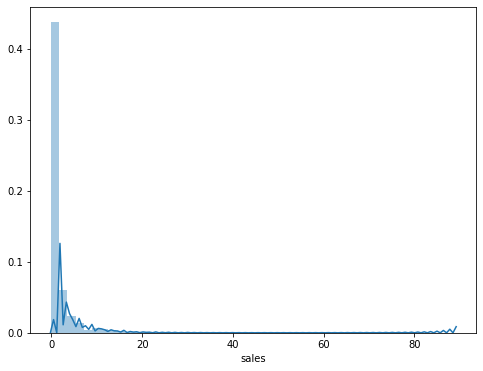

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df['sales'][:200000])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 342559 to 46878802
Data columns (total 40 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           int16         
 3   store_id          int16         
 4   cat_id            int16         
 5   state_id          int16         
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           uint8         
 11  wday              uint8         
 12  month             uint8         
 13  year              int16         
 14  event_name_1      uint8         
 15  event_type_1      uint8         
 16  event_name_2      uint8         
 17  event_type_2      uint8         
 18  snap_CA           uint8         
 19  snap_TX           uint8         
 20  snap_WI           uint8         
 21  b

In [25]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id', 
             "event_name_1", "event_name_2", "event_type_1", "event_type_2", 'snap_CA', 'snap_TX', 'snap_WI']
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "revenue"]
train_cols = df.columns[~df.columns.isin(useless_cols)]

In [26]:
X_train = df[train_cols]
y_train = df["sales"]

In [27]:
# 312, 278, 845
m5_common.seed_everything(312)

size_valid_set = 2_000_000
fake_valid_inds = np.random.choice(X_train.index.values, size_valid_set, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)

X = X_train.loc[train_inds]
y = y_train.loc[train_inds]

X_valid = X_train.loc[fake_valid_inds]
y_valid = y_train.loc[fake_valid_inds]

In [28]:
del df 
gc.collect()

27

### Training 

In [29]:
if not 'n_estimators' in locals():
    n_estimators = 1300
    
if not 'tweedie_variance_power' in locals():
    tweedie_variance_power = 1.28
    
if not 'sub_row' in locals():
    sub_row = 0.75
    
if not 'bagging_freq' in locals():
    bagging_freq = 1
    
if not 'learning_rate' in locals():
    learning_rate = 0.075

leave_size = 10
params = {
    'boosting_type': 'gbdt',
    "objective" : "tweedie",
    'tweedie_variance_power': tweedie_variance_power,
    "metric" :"rmse",
    "force_row_wise" : True,
    "learning_rate" : learning_rate,
#         "sub_feature" : 0.8,
    "sub_row" : sub_row,
    "bagging_freq" : bagging_freq,
#         "lambda_l1" : 0.2,
    "lambda_l2" : 0.1,
    "nthread" : 10,
    "metric": ["rmse"],
    'verbosity': 20,
    'num_leaves': 2**leave_size-1,
    "min_data_in_leaf": 2**(leave_size + 1)-1,
    "n_estimators": n_estimators
}

In [30]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'tweedie',
#     'tweedie_variance_power': 1.1,
#     'metric': 'rmse',
#     'subsample': 0.5,
#     'subsample_freq': 1,
#     'learning_rate': 0.03,
#     'num_leaves': 2**11-1,
#     'min_data_in_leaf': 2**12-1,
#     'feature_fraction': 0.5,
#     'max_bin': 100,
#     'n_estimators': 1400,
#     'boost_from_average': False,
# #     'verbose': -1,
#     'verbosity': 20,
# } 

In [31]:
m_lgb_regressor = lgb.LGBMRegressor(**params)

In [32]:
%%time

m_lgb_regressor.fit(X=X, y=y, 
          eval_set=[(X, y), (X_valid, y_valid)],
          eval_names=['train sales', 'valid sales'], 
          eval_metric=params['metric'],
          verbose=params['verbosity'],
          early_stopping_rounds=100,
          categorical_feature=cat_feats)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_id', 'dept_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2', 'item_id', 'snap_CA', 'snap_TX', 'snap_WI', 'state_id', 'store_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[20]	train sales's rmse: 2.82515	valid sales's rmse: 2.76772
[40]	train sales's rmse: 2.29703	valid sales's rmse: 2.25478
[60]	train sales's rmse: 2.22452	valid sales's rmse: 2.18978
[80]	train sales's rmse: 2.19659	valid sales's rmse: 2.1693
[100]	train sales's rmse: 2.18206	valid sales's rmse: 2.16053
[120]	train sales's rmse: 2.17116	valid sales's rmse: 2.15363
[140]	train sales's rmse: 2.16286	valid sales's rmse: 2.14806
[160]	train sales's rmse: 2.15571	valid sales's rmse: 2.14326
[180]	train sales's rmse: 2.14953	valid sales's rmse: 2.1399
[200]	train sales's rmse: 2.14342	valid sales's rmse: 2.13645
[220]	train sales's rmse: 2.1389	valid sales's rmse: 2.13408
[240]	train sales's rmse: 2.13407	valid sales's rmse: 2.13139
[260]	train sales's rmse: 2.12962	valid sales's rmse: 2.12954
[280]	train sales's rmse: 2.12488	valid sales's rmse: 2.12718
[300]	train sales's rmse: 2.12129	valid sales's rmse: 2.12558
[320]	train sal

LGBMRegressor(bagging_freq=1, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, force_row_wise=True,
              importance_type='split', lambda_l2=0.1, learning_rate=0.075,
              max_depth=-1, metric=['rmse'], min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=2047, min_split_gain=0.0,
              n_estimators=1300, n_jobs=-1, nthread=10, num_leaves=1023,
              objective='tweedie', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, sub_row=0.75, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0,
              tweedie_variance_power=1.28, verbosity=20)

In [33]:
class Importance():
    
    def __init__(self, model, eval_metric):
        self.model, self.eval_metric = model, eval_metric
        self.feature_importances = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats, ax=ax)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]
    
    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in [self.model]:
            evals_result = pd.DataFrame()
            for k in model.evals_result_.keys():
                evals_result[k] = model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
#         categorical_feature  plt.title('Training progress')

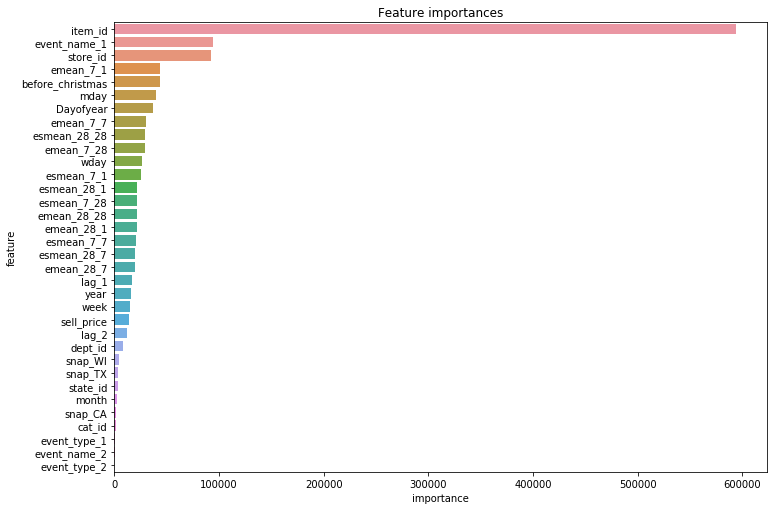

In [34]:
importance = Importance(m_lgb_regressor, 'rmse')
importance.plot_feature_importance(top_n=40)

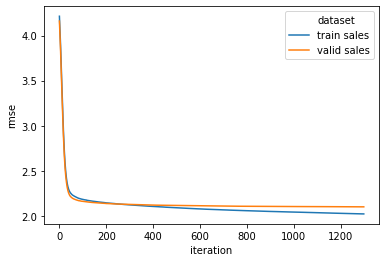

In [35]:
importance.plot_metric()

In [36]:
booster_file_path = m5_common.save_booster(m_lgb_regressor, path, prefix='private')

In [37]:
# for iter in [None, 800, 1000, 1200]:
#     m_lgb_regressor.booster_.save_model(str(path/f"m5_model_{'best' if iter is None else iter}.lgb"), num_iteration=iter)

In [38]:
# !tar -czvf /kaggle/m5_forecasting/m5_model_best.lgb.tgz {booster_file_path}
booster_file_path

'/kaggle/m5_forecasting/m5_model_private25_6_2020_15'

## Prediction

In [39]:
m_lgb = lgb.Booster(model_file=str(booster_file_path))

In [40]:
!du -h {booster_file_path}

294M	/kaggle/m5_forecasting/m5_model_private25_6_2020_15


In [41]:
from tqdm.notebook import tqdm

In [42]:
%%time

max_lags = h * 2 + 1
sub = 0.
cols = [f"F{i}" for i in range(1,29)]
te = m5_common.create_dt(cal, prices, False, first_day=FIRST_DAY, tr_last=tr_last, path=path)

for tdelta in tqdm(range(0, h), total=h):
    day = fday + timedelta(days=tdelta)
    print(tdelta, day)
    tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
    m5_common.create_fea(tst, False)
    tst = tst.loc[tst.date == day, train_cols]
    te.loc[te.date == day, "sales"] = m_lgb.predict(tst)

0 2016-05-23 00:00:00
1 2016-05-24 00:00:00
2 2016-05-25 00:00:00
3 2016-05-26 00:00:00
4 2016-05-27 00:00:00
5 2016-05-28 00:00:00
6 2016-05-29 00:00:00
7 2016-05-30 00:00:00
8 2016-05-31 00:00:00
9 2016-06-01 00:00:00
10 2016-06-02 00:00:00
11 2016-06-03 00:00:00
12 2016-06-04 00:00:00
13 2016-06-05 00:00:00
14 2016-06-06 00:00:00
15 2016-06-07 00:00:00
16 2016-06-08 00:00:00
17 2016-06-09 00:00:00
18 2016-06-10 00:00:00
19 2016-06-11 00:00:00
20 2016-06-12 00:00:00
21 2016-06-13 00:00:00
22 2016-06-14 00:00:00
23 2016-06-15 00:00:00
24 2016-06-16 00:00:00
25 2016-06-17 00:00:00
26 2016-06-18 00:00:00
27 2016-06-19 00:00:00

CPU times: user 53min 46s, sys: 13.9 s, total: 53min 59s
Wall time: 25min 11s


In [43]:
te.loc[te.date == day, "sales"]

47677642    0.778320
47683740    1.066406
47689838    1.672852
47695936    0.190430
47702034    0.361328
              ...   
47708130    0.236572
47714228    0.204590
47720326    0.093994
47726424    0.055450
47732522    0.077698
Name: sales, Length: 30490, dtype: float16

In [44]:
te_sub = te.loc[te.date >= fday - timedelta(days=h), ["id", "sales"]].copy()

In [45]:
te_sub

,id,sales
45978263,FOODS_1_001_CA_1_evaluation,2.000000
45978264,FOODS_1_001_CA_1_evaluation,0.000000
45978265,FOODS_1_001_CA_1_evaluation,0.000000
45978266,FOODS_1_001_CA_1_evaluation,0.000000
45978267,FOODS_1_001_CA_1_evaluation,0.000000
...,...,...
47664355,HOUSEHOLD_2_516_WI_3_evaluation,0.069458
47664356,HOUSEHOLD_2_516_WI_3_evaluation,0.075195
47664357,HOUSEHOLD_2_516_WI_3_evaluation,0.114868
47732521,HOUSEHOLD_2_516_WI_3_evaluation,0.143799


In [46]:
day_filter = (te.date >= fday - timedelta(days=h)) & (te.date < fday)

te_sub.loc[day_filter, "id"] = te_sub.loc[day_filter, "id"].str.replace("evaluation$", "validation")
te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
te_sub.fillna(0., inplace = True)
te_sub.sort_values("id", inplace = True)
te_sub.reset_index(drop=True, inplace = True)
sub = te_sub

In [47]:
sub

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.831055,0.725098,0.683105,0.644531,0.677246,0.942871,0.752930,0.554688,0.830566,0.841309,0.755371,0.888672,1.244141,0.868652,0.859375,0.641113,0.580078,0.629883,0.771973,0.810059,1.148438,0.608887,0.809570,0.606934,0.578125,0.598633,0.869629,0.778320
1,FOODS_1_001_CA_1_validation,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,6.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,FOODS_1_001_CA_2_evaluation,1.021484,0.779785,0.759277,0.702148,0.849121,1.092773,1.054688,0.954590,0.953125,1.160156,1.138672,1.086914,1.340820,1.207031,0.859863,0.736816,0.806152,1.078125,0.831055,1.391602,1.089844,0.855469,0.764160,0.833496,0.827148,1.196289,1.086914,1.066406
3,FOODS_1_001_CA_2_validation,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000
4,FOODS_1_001_CA_3_evaluation,0.800781,0.772949,0.789551,0.854980,0.979980,1.359375,1.555664,1.340820,0.798828,0.991211,1.147461,1.190430,1.416016,1.832031,1.251953,0.979004,1.026367,1.070312,0.952148,1.496094,1.393555,1.090820,1.099609,1.024414,0.980957,1.013672,1.318359,1.672852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,HOUSEHOLD_2_516_WI_1_validation,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
60976,HOUSEHOLD_2_516_WI_2_evaluation,0.074585,0.077271,0.089966,0.076904,0.098511,0.102051,0.104065,0.045898,0.096008,0.090027,0.049347,0.098389,0.109192,0.107788,0.073547,0.055756,0.075684,0.074402,0.105713,0.118835,0.093384,0.077148,0.078186,0.064697,0.061218,0.279785,0.095886,0.055450
60977,HOUSEHOLD_2_516_WI_2_validation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60978,HOUSEHOLD_2_516_WI_3_evaluation,0.103333,0.097717,0.096985,0.100037,0.140747,0.156860,0.125977,0.055908,0.107056,0.083557,0.051849,0.109680,0.126953,0.109131,0.078613,0.066345,0.076355,0.073364,0.134644,0.134399,0.119812,0.067444,0.066467,0.069458,0.075195,0.114868,0.143799,0.077698


In [48]:
%time

sub_validation = sub[sub['id'].str.contains("validation")].copy()
sub_evaluation = sub[sub['id'].str.contains("evaluation")].copy()
sub = pd.concat([sub_validation, sub_evaluation], axis=0, sort=False)
sub.to_csv("submission.csv",index=False)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [49]:
sub

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
1,FOODS_1_001_CA_1_validation,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,6.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3,FOODS_1_001_CA_2_validation,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000
5,FOODS_1_001_CA_3_validation,1.000000,0.000000,1.000000,0.000000,8.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000,3.000000,2.000000,2.000000
7,FOODS_1_001_CA_4_validation,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
9,FOODS_1_001_TX_1_validation,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,0.000000,2.000000,2.000000,0.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60970,HOUSEHOLD_2_516_TX_2_evaluation,0.303955,0.193604,0.187378,0.388672,0.473389,0.352051,0.353760,0.132935,0.169800,0.291016,0.140503,0.257324,0.381836,0.338379,0.246826,0.303223,0.186890,0.178955,0.272705,0.425781,0.529297,0.260010,0.160767,0.163696,0.330078,0.241821,0.366211,0.236572
60972,HOUSEHOLD_2_516_TX_3_evaluation,0.156494,0.199097,0.414307,0.442627,0.322266,0.387451,0.387451,0.212280,0.252441,0.231445,0.218628,0.206543,0.299072,0.346191,0.156982,0.195190,0.168579,0.170166,0.278076,0.330811,0.278076,0.145264,0.176147,0.175171,0.179810,0.236206,0.367432,0.204590
60974,HOUSEHOLD_2_516_WI_1_evaluation,0.065002,0.077087,0.090637,0.106689,0.118774,0.140747,0.113586,0.045685,0.086182,0.079773,0.059692,0.106079,0.199097,0.181152,0.084778,0.071472,0.095276,0.088501,0.140869,0.345947,0.124329,0.077637,0.080322,0.065796,0.073486,0.129028,0.141357,0.093994
60976,HOUSEHOLD_2_516_WI_2_evaluation,0.074585,0.077271,0.089966,0.076904,0.098511,0.102051,0.104065,0.045898,0.096008,0.090027,0.049347,0.098389,0.109192,0.107788,0.073547,0.055756,0.075684,0.074402,0.105713,0.118835,0.093384,0.077148,0.078186,0.064697,0.061218,0.279785,0.095886,0.055450


In [50]:
check = pd.read_csv('submission.csv')
check[(check['id'] == 'FOODS_1_001_CA_1_validation') | (check['id'] == 'FOODS_1_001_CA_1_evaluation')]

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,2.000,0.000,0.000,0.0000,0.0000,1.000,1.000,0.0000,6.0000,1.0000,0.0000,3.0000,0.000,0.0000,0.0000,2.000,0.00,0.00,2.000,3.00,1.000,0.000,0.0000,0.000,1.000,0.0000,0.0000,0.0000
30490,FOODS_1_001_CA_1_evaluation,0.831,0.725,0.683,0.6445,0.6772,0.943,0.753,0.5547,0.8306,0.8413,0.7554,0.8887,1.244,0.8687,0.8594,0.641,0.58,0.63,0.772,0.81,1.148,0.609,0.8096,0.607,0.578,0.5986,0.8696,0.7783


In [51]:
check

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,2.00000,0.0000,0.00000,0.00000,0.0000,1.00000,1.00000,0.0000,6.00000,1.00000,0.00000,3.0000,0.0000,0.00000,0.00000,2.00000,0.00000,0.00000,2.0000,3.00000,1.0000,0.00000,0.00000,0.00000,1.00000,0.00000,0.0000,0.00000
1,FOODS_1_001_CA_2_validation,0.00000,3.0000,0.00000,0.00000,0.0000,1.00000,4.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,1.00000,2.00000,1.00000,0.00000,1.0000,0.00000,0.0000,1.00000,1.00000,0.00000,0.00000,1.00000,2.0000,0.00000
2,FOODS_1_001_CA_3_validation,1.00000,0.0000,1.00000,0.00000,8.0000,1.00000,0.00000,0.0000,1.00000,0.00000,0.00000,1.0000,1.0000,0.00000,0.00000,0.00000,0.00000,0.00000,1.0000,2.00000,2.0000,0.00000,0.00000,1.00000,0.00000,3.00000,2.0000,2.00000
3,FOODS_1_001_CA_4_validation,0.00000,1.0000,0.00000,0.00000,0.0000,0.00000,1.00000,0.0000,0.00000,0.00000,0.00000,0.0000,1.0000,0.00000,0.00000,0.00000,0.00000,0.00000,1.0000,0.00000,0.0000,0.00000,0.00000,1.00000,1.00000,0.00000,0.0000,0.00000
4,FOODS_1_001_TX_1_validation,0.00000,0.0000,1.00000,0.00000,1.0000,0.00000,1.00000,1.0000,1.00000,1.00000,0.00000,0.0000,2.0000,1.00000,0.00000,1.00000,0.00000,1.00000,1.0000,1.00000,1.0000,1.00000,5.00000,0.00000,2.00000,2.00000,0.0000,2.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,HOUSEHOLD_2_516_TX_2_evaluation,0.30400,0.1936,0.18740,0.38870,0.4734,0.35200,0.35380,0.1329,0.16980,0.29100,0.14050,0.2573,0.3818,0.33840,0.24680,0.30320,0.18690,0.17900,0.2727,0.42580,0.5293,0.26000,0.16080,0.16370,0.33000,0.24180,0.3662,0.23660
60976,HOUSEHOLD_2_516_TX_3_evaluation,0.15650,0.1991,0.41430,0.44260,0.3223,0.38750,0.38750,0.2123,0.25240,0.23140,0.21860,0.2065,0.2990,0.34620,0.15700,0.19520,0.16860,0.17020,0.2780,0.33080,0.2780,0.14530,0.17610,0.17520,0.17980,0.23620,0.3674,0.20460
60977,HOUSEHOLD_2_516_WI_1_evaluation,0.06500,0.0771,0.09064,0.10670,0.1188,0.14070,0.11360,0.0457,0.08620,0.07980,0.05970,0.1061,0.1991,0.18120,0.08480,0.07150,0.09530,0.08850,0.1409,0.34600,0.1243,0.07764,0.08030,0.06580,0.07350,0.12900,0.1414,0.09400
60978,HOUSEHOLD_2_516_WI_2_evaluation,0.07460,0.0773,0.08997,0.07690,0.0985,0.10205,0.10406,0.0459,0.09600,0.09000,0.04935,0.0984,0.1092,0.10780,0.07355,0.05576,0.07570,0.07440,0.1057,0.11884,0.0934,0.07715,0.07820,0.06470,0.06122,0.27980,0.0959,0.05545
